Demo notebook for ptycho

Arthur McCray  
Last remembered to update this line: 8/25/25

In [1]:
%load_ext autoreload
%autoreload 2 

In [ ]:
from pathlib import Path

import numpy as np
import quantem as em
import torch
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.core.ml.cnn2d import CNN2d
from quantem.core.utils.utils import electron_wavelength_angstrom
from quantem.core.visualization import show_2d
from quantem.diffractive_imaging.dataset_models import PtychographyDatasetRaster
from quantem.diffractive_imaging.detector_models import DetectorPixelated
from quantem.diffractive_imaging.object_models import ObjectDIP, ObjectPixelated
from quantem.diffractive_imaging.probe_models import ProbeDIP, ProbePixelated
from quantem.diffractive_imaging.ptychography import Ptychography


GPU_ID = 0
config.set_device(GPU_ID)
print(f"Using GPU {config.get('device')}")


/home/amccray/code/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:3


# White noise

In [3]:
# parameters
N = 64
Q_MAX = 0.5 # inverse Angstroms
q_probe = Q_MAX/2 # inverse Angstroms
PROBE_ENERGY = 300e3 # eV
wavelength = electron_wavelength_angstrom(PROBE_ENERGY) 
sampling = 1 / Q_MAX / 2 # Angstroms
reciprocal_sampling = 2 * Q_MAX / N # inverse Angstroms, set so that no upsampling

SCAN_STEP_SIZE = 1 # pixels
sx = sy = N//SCAN_STEP_SIZE
phi0 = 1
C10 = 50

In [4]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(N,phi0)
complex_obj = np.exp(1j*potential)

In [5]:
qx = qy = np.fft.fftfreq(N,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)

aperture_fourier = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

chi = q**2 * wavelength * np.pi * C10
exp_chi = np.exp(-1j*chi)
probe_array_fourier = aperture_fourier * exp_chi
probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))
probe_array = np.fft.ifft2(probe_array_fourier) * N

In [6]:
def return_patch_indices(positions_px,roi_shape,obj_shape):
    """ """
    x0 = np.round(positions_px[:, 0]).astype("int")
    y0 = np.round(positions_px[:, 1]).astype("int")

    x_ind = np.fft.fftfreq(roi_shape[0], d=1 / roi_shape[0]).astype("int")
    y_ind = np.fft.fftfreq(roi_shape[1], d=1 / roi_shape[1]).astype("int")

    row = (x0[:, None, None] + x_ind[None, :, None]) % obj_shape[0]
    col = (y0[:, None, None] + y_ind[None, None, :]) % obj_shape[1]

    return row, col

In [7]:
def simulate_exit_waves(
    complex_obj,
    probe,
    row,
    col,
):
    """ """
    obj_patches = complex_obj[row,col]
    exit_waves = obj_patches * probe
    return obj_patches, exit_waves

def simulate_intensities(
    complex_obj,
    probe,
    row,
    col,
):
    """ """
    obj_patches, exit_waves = simulate_exit_waves(
        complex_obj,
        probe,
        row,
        col
    )
    fourier_exit_waves = np.fft.fft2(exit_waves)
    intensities = np.abs(fourier_exit_waves)**2
    return obj_patches, exit_waves, fourier_exit_waves, intensities

x = y = np.arange(0.,N,SCAN_STEP_SIZE)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)

sim_row, sim_col = return_patch_indices(positions,(N,N),(N,N))

obj_patches, exit_waves, fourier_exit_waves, intensities = simulate_intensities(
    complex_obj,
    probe_array,
    sim_row,
    sim_col
)

In [8]:
dset = Dataset4dstem.from_array( 
    array = np.fft.fftshift(intensities, axes=(-2,-1)).reshape((sx, sy, N, N)),
    sampling = (SCAN_STEP_SIZE, SCAN_STEP_SIZE, reciprocal_sampling, reciprocal_sampling),
    units=("A", "A", "A^-1", "A^-1"),
)

## ptycho

In [9]:
pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)

pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=False,
    plot_com=False,
    probe_energy = PROBE_ENERGY,
    force_com_rotation=0, 
    force_com_transpose=False, 
)

Forcing best fit rotation to 0 degrees.
Forcing transpose of intensities to False.


Normalizing intensities: 100%|██████████| 4096/4096 [00:01<00:00, 3863.89probe position/s]


In [10]:
obj_model = ObjectPixelated.from_uniform(
    num_slices=1,
    obj_type='complex',
    slice_thicknesses=10
)

probe_params = {
    "energy" : PROBE_ENERGY,
    "C10" : C10,
    "semiangle_cutoff" : wavelength*1e3, 
}

probe_model = ProbePixelated.from_array(
    num_probes=1,
    probe_array = probe_array, 
)

detector_model = DetectorPixelated() 


ptycho = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model,
    probe_model=probe_model,
    detector_model=detector_model,
    rng = 42, 
)

ptycho.preprocess( 
    obj_padding_px=(0,0),
);

Epoch 50/50, Loss: 9.623e-06: 100%|██████████| 50/50 [00:01<00:00, 42.85it/s]


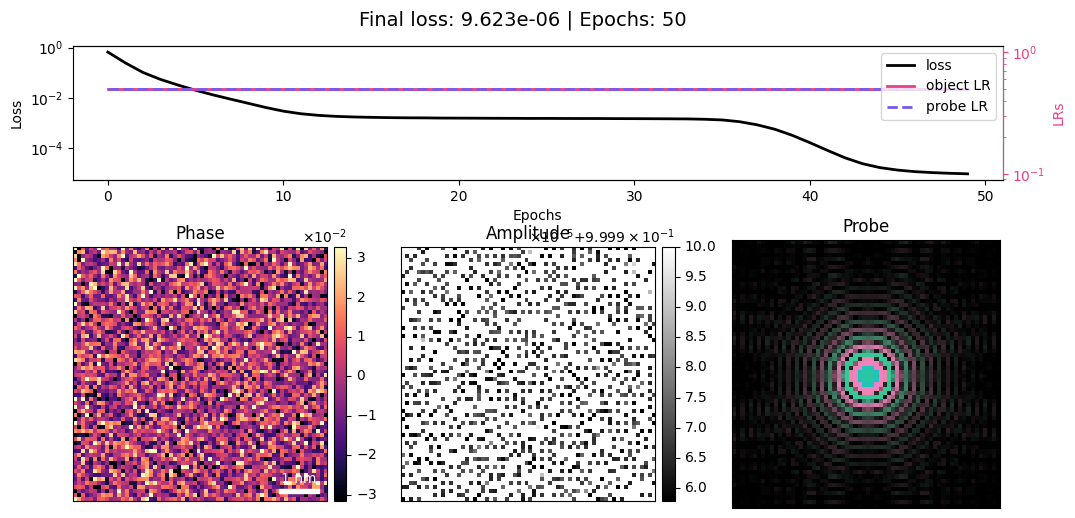

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'SGD optimizers autograd False'}>)

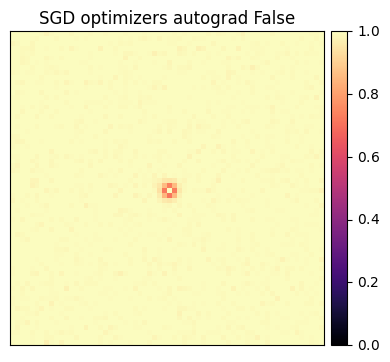

In [11]:
opt_params = { 
        "object": {
            "type": torch.optim.SGD, 
            "lr": 0.5, 
        },
        "probe": {
            "type": "sgd", 
            "lr": 0.5, 
        },
}

scheduler_params = {
}

constraints = {
}


ptycho.reconstruct(
    num_iter=50,
    reset=True,
    autograd=False, 
    device='gpu',
    constraints=constraints, 
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    batch_size= N**2 // 8,
).visualize()

show_2d(
    np.fft.fftshift(
        np.abs(
            np.fft.fft2(
                ptycho.obj.sum(0)
            )
        )
    ),
    cbar=True, 
    cmap='magma', 
    vmin=0, vmax=1,
    title="SGD optimizers autograd False"
)

Epoch 50/50, Loss: 1.464e-06: 100%|██████████| 50/50 [00:02<00:00, 19.41it/s]


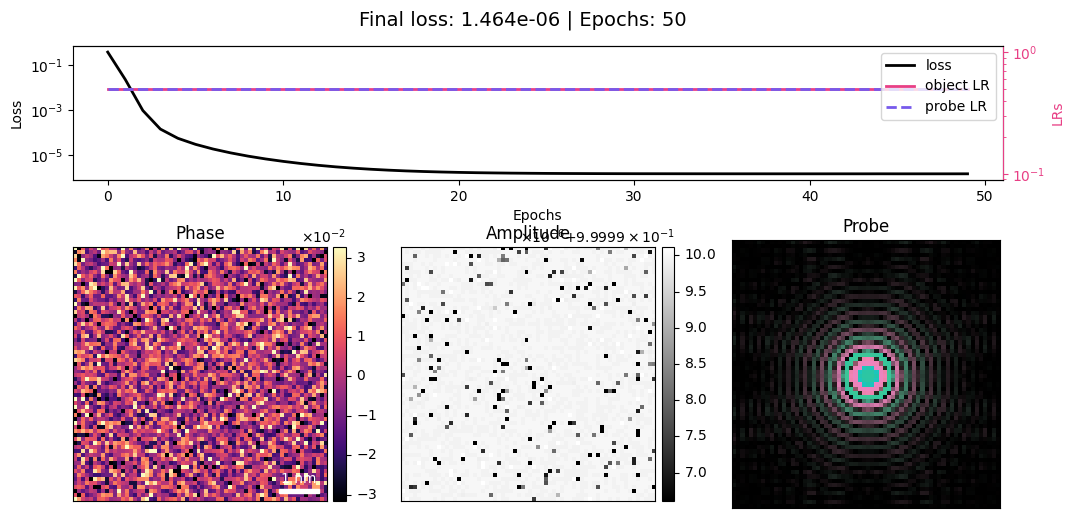

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'SGD optimizers autograd True'}>)

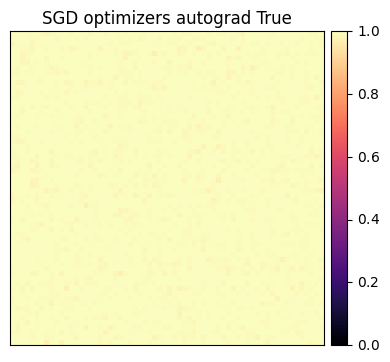

In [12]:
opt_params = { 
        "object": {
            "type": torch.optim.SGD, 
            "lr": 0.5, 
        },
        "probe": {
            "type": "sgd", 
            "lr": 0.5, 
        },
}

ptycho.reconstruct(
    num_iter=50,
    reset=True,
    autograd=True, 
    optimizer_params=opt_params,
).visualize()

show_2d(
    np.fft.fftshift(
        np.abs(
            np.fft.fft2(
                ptycho.obj.sum(0)
            )
        )
    ),
    cbar=True, 
    cmap='magma', 
    vmin=0, vmax=1,
    title="SGD optimizers autograd True"
)

Epoch 50/50, Loss: 2.157e-06: 100%|██████████| 50/50 [00:01<00:00, 48.28it/s]


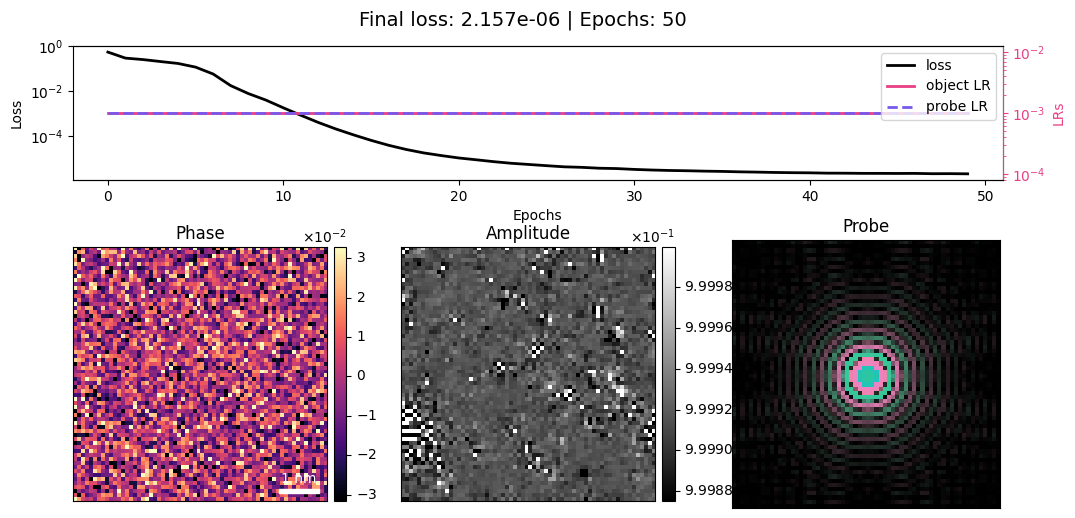

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'Adam optimizers autograd False'}>)

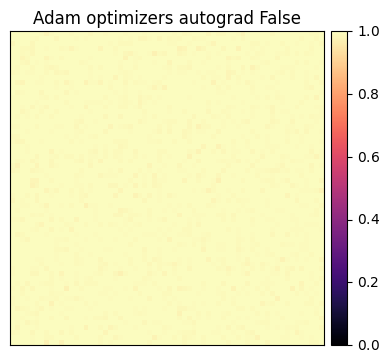

In [13]:
opt_params = { 
        "object": {
            "type": "adam", 
            "lr": 1e-3, 
        },
        "probe": {
            "type": "adam", 
            "lr": 1e-3, 
        },
}

ptycho.reconstruct(
    num_iter=50,
    reset=True,
    autograd=False, 
    optimizer_params=opt_params,
    batch_size= N**2 // 8,
).visualize()

show_2d(
    np.fft.fftshift(
        np.abs(
            np.fft.fft2(
                ptycho.obj.sum(0)
            )
        )
    ),
    cbar=True, 
    cmap='magma', 
    vmin=0, vmax=1,
    title="Adam optimizers autograd False"
)

Epoch 50/50, Loss: 1.586e-06: 100%|██████████| 50/50 [00:01<00:00, 36.24it/s]


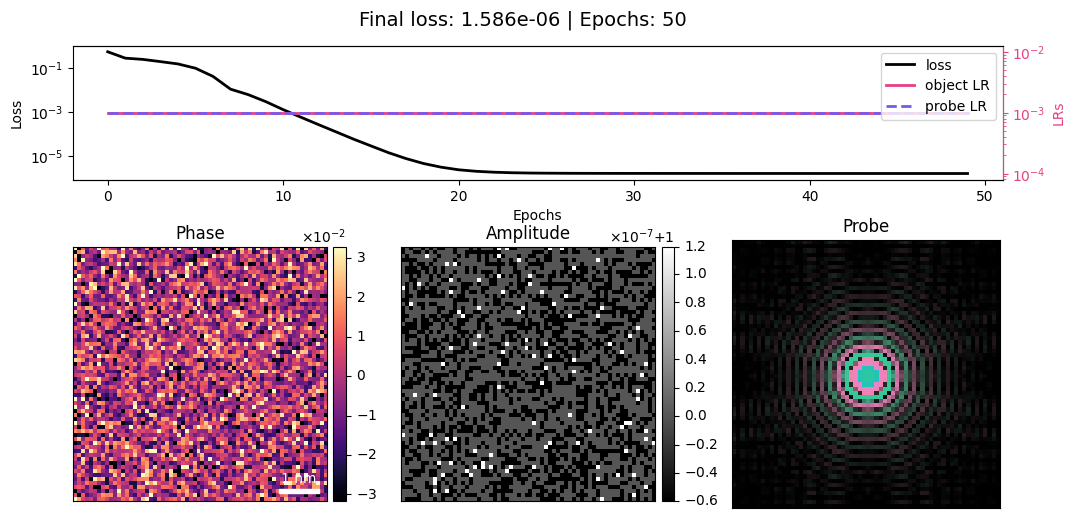

(<Figure size 400x400 with 2 Axes>,
 <Axes: title={'center': 'Adam optimizers autograd True'}>)

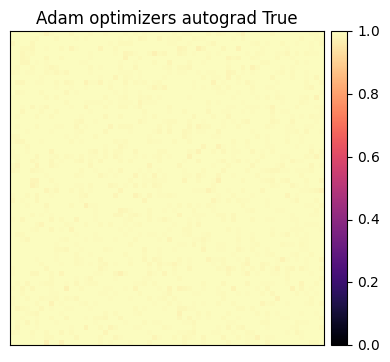

In [14]:
opt_params = { 
        "object": {
            "type": "adam", 
            "lr": 1e-3, 
        },
        "probe": {
            "type": "adam", 
            "lr": 1e-3, 
        },
}

ptycho.reconstruct(
    num_iter=50,
    reset=True,
    autograd=True, 
    optimizer_params=opt_params,
    batch_size= N**2 // 8,
).visualize()

show_2d(
    np.fft.fftshift(
        np.abs(
            np.fft.fft2(
                ptycho.obj.sum(0)
            )
        )
    ),
    cbar=True, 
    cmap='magma', 
    vmin=0, vmax=1,
    title="Adam optimizers autograd True"
)

# Ducky

In [15]:
data_dir = Path("../data").expanduser()
file_data = data_dir / "ducky_clean.zip"
dset: Dataset4dstem = em.io.load(file_data)

Calculated best fit rotation = 0 degrees.


Normalizing intensities: 100%|██████████| 625/625 [00:00<00:00, 1334.47probe position/s]


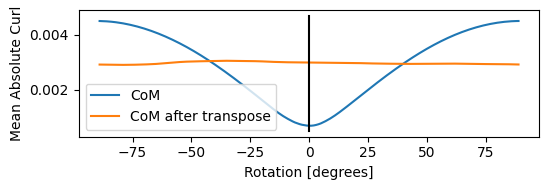

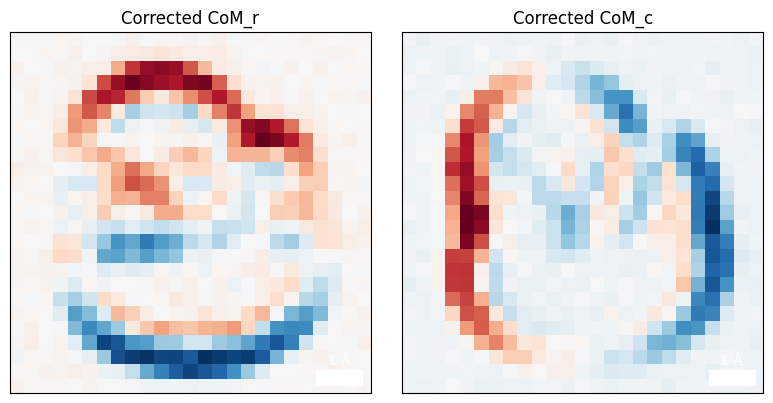

In [16]:
pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)

pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=True,
    plot_com=True,
)

## pixelated
- tensorboard logging is optional 

In [17]:
from quantem.diffractive_imaging.logger_ptychography import LoggerPtychography

logger = None
# logger = LoggerPtychography(
#     # log_dir = "../logs/",
#     log_dir = data_dir / "logs",
#     run_prefix=dset.name,
#     run_suffix="",
#     log_images_every=10,
#     log_probe_images=False,
# )

In [18]:
obj_model = ObjectPixelated.from_uniform(
    num_slices=1,
    slice_thicknesses=10,
    obj_type="pure_phase",
)

probe_params = {
    "energy": 80e3,
    "defocus": 500,
    "semiangle_cutoff": 20,
}

probe_model = ProbePixelated.from_params(
    num_probes=1,
    probe_params=probe_params,
)

detector_model = DetectorPixelated()

ptycho = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model,
    probe_model=probe_model,
    detector_model=detector_model,
    logger=logger,
    rng=42, 
)

ptycho.preprocess(
    obj_padding_px=(32, 32),
)

Epoch 1/50, Loss: 1.265e+01:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50, Loss: 1.709e+00: 100%|██████████| 50/50 [00:01<00:00, 31.25it/s]


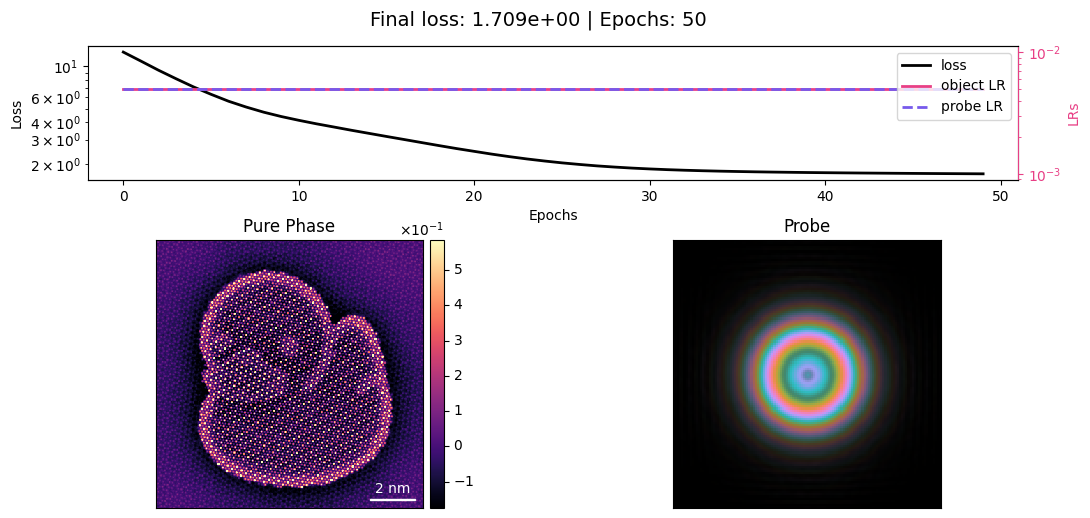

In [31]:
# this vs having a single lr for all params from dataset (currently just scan positions and descan)
opt_params = {  # except type, all args are passed to the optimizer (of type type)
    "object": {
        "type": "adam",
        "lr": 5e-3,
    },
    "probe": {
        "type": "adam",
        "lr": 5e-3,
    },
    # "dataset": { ### descan and/or scan positions (not super well specified yet)
    #     "type": "adam",
    #     "lr": 1e-2,
    # }
}

scheduler_params = {
    "object": {
        # "type": "exp",
        # "factor": 0.1,
        "type": "plateau",
        "threshold": 5e-3,
        # "patience": 100,
        # "cooldown": 100,
    },
    "probe": {
        # "type": "exp",
        # "factor": 0.5,
        "type": "plateau",
        "threshold": 5e-3,
        # "patience": 100,
        # "cooldown": 100,
    }
    # "dataset" - cover descan and scan positions
}

constraints = {
    "object": {
        # "tv_weight_yx": 0., 
        # "tv_weight_z": 0,
        # "fix_potential_baseline": True,
        # "identical_slices": True,
    },
    "probe": {
        # "center_probe": False,
        # "tv_weight": 0.,
    },
    # "dataset":{
    #     "descan_tv_weight": 0,
    #     # "descan_shifts_constant": False,
    # }
}

ptycho.reconstruct(
    num_iter=50,
    reset=True,
    autograd=True,
    device="gpu",
    constraints=constraints,
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    batch_size=125,
).visualize()


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'pixelated pure_phase | 50 epochs'}>,
        <Axes: title={'center': 'zoom'}>, <Axes: title={'center': 'zoom'}>],
       dtype=object))

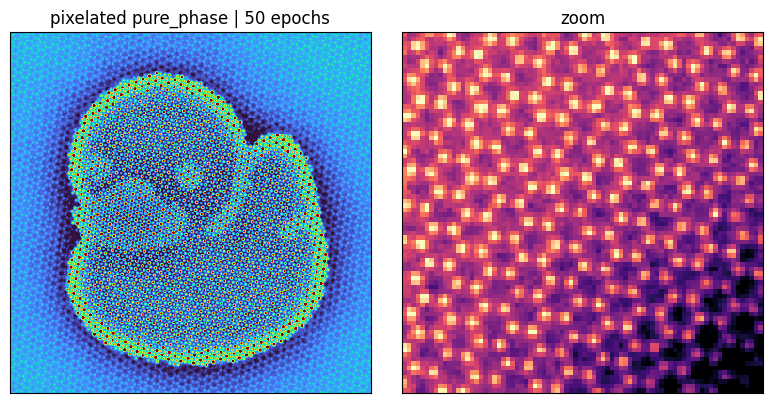

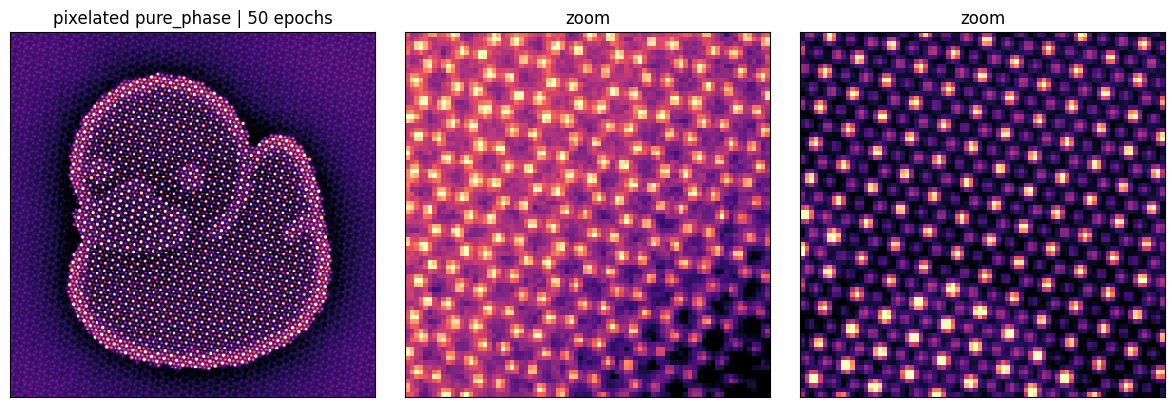

In [32]:
show_2d(
    [np.angle(ptycho.obj_cropped[0]), np.angle(ptycho.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title = [
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs",
        "zoom",
    ]
)
show_2d(
    [
        np.angle(ptycho.obj_cropped[0]),
        np.angle(ptycho.obj_cropped[0, :80, :80]),
        np.angle(ptycho.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs",
        "zoom",
        "zoom",
    ],
)

Epoch 450/450, Loss: 1.482e+00: 100%|██████████| 450/450 [00:10<00:00, 41.77it/s]


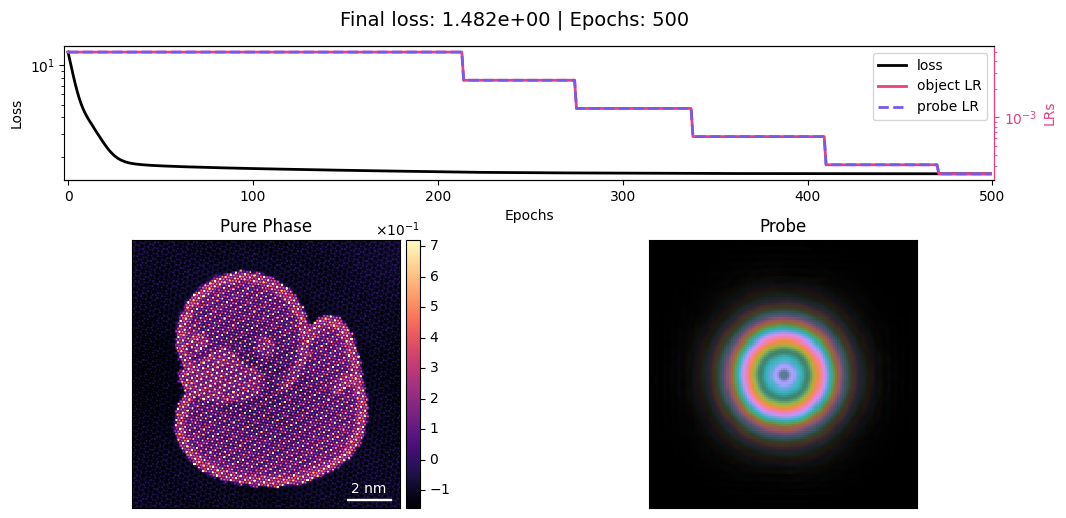

In [33]:
ptycho.reconstruct(
    num_iter=450,
).visualize()


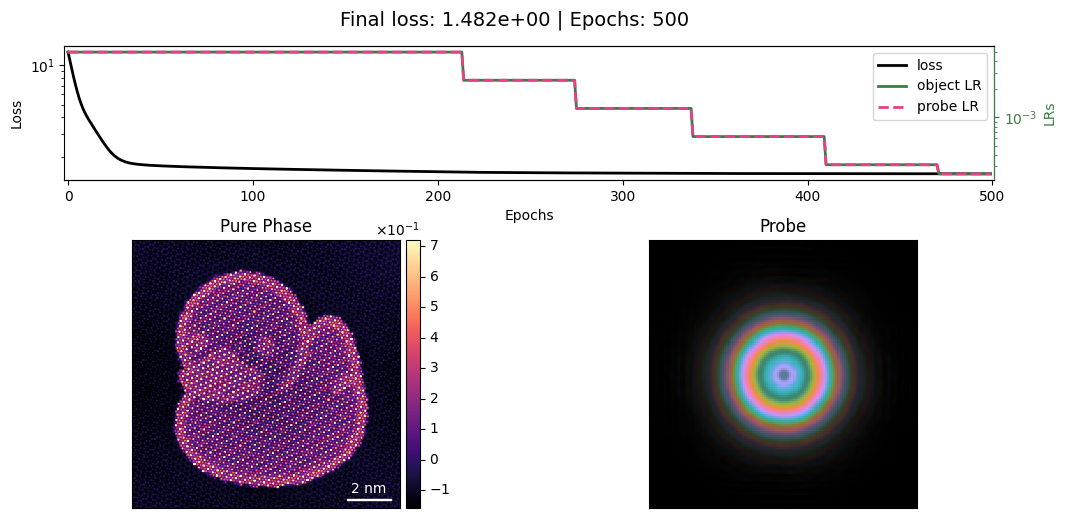

In [39]:
ptycho.visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'pixelated pure_phase | 500 epochs'}>,
        <Axes: title={'center': 'zoom'}>, <Axes: title={'center': 'zoom'}>],
       dtype=object))

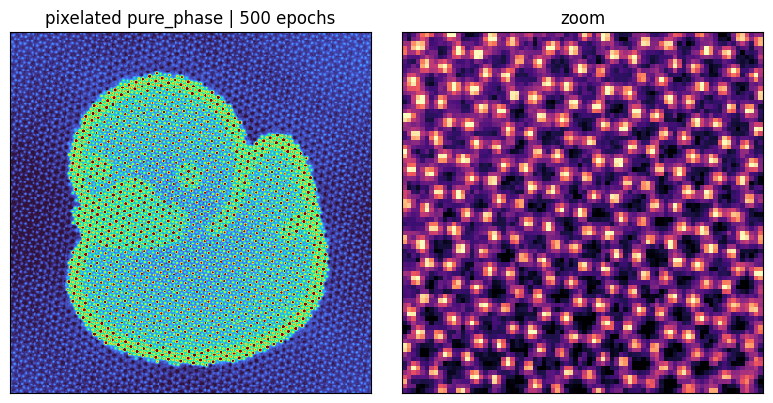

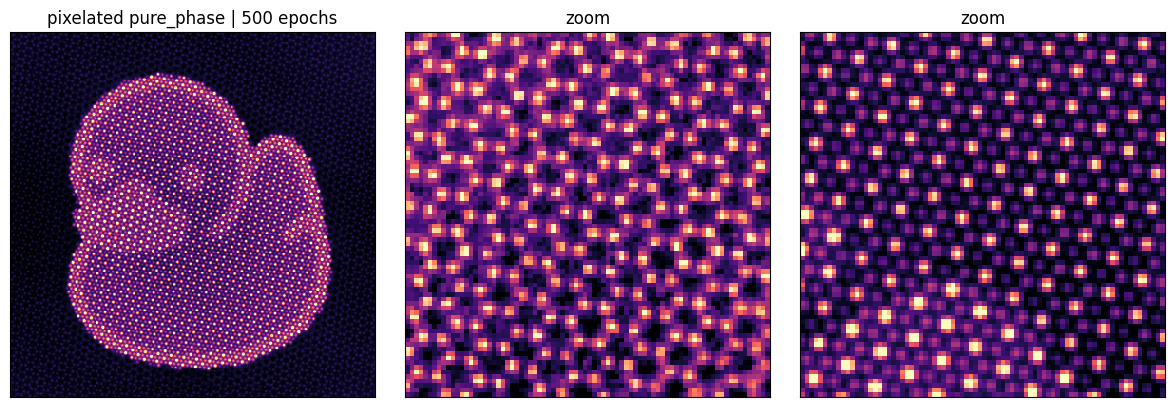

In [35]:
show_2d(
    [np.angle(ptycho.obj_cropped[0]), np.angle(ptycho.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title = [
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs",
        "zoom",
    ]
)
show_2d(
    [
        np.angle(ptycho.obj_cropped[0]),
        np.angle(ptycho.obj_cropped[0, :80, :80]),
        np.angle(ptycho.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs",
        "zoom",
        "zoom",
    ],
)

Epoch 10/10, Loss: 4.383e+00: 100%|██████████| 10/10 [00:00<00:00, 35.93it/s]


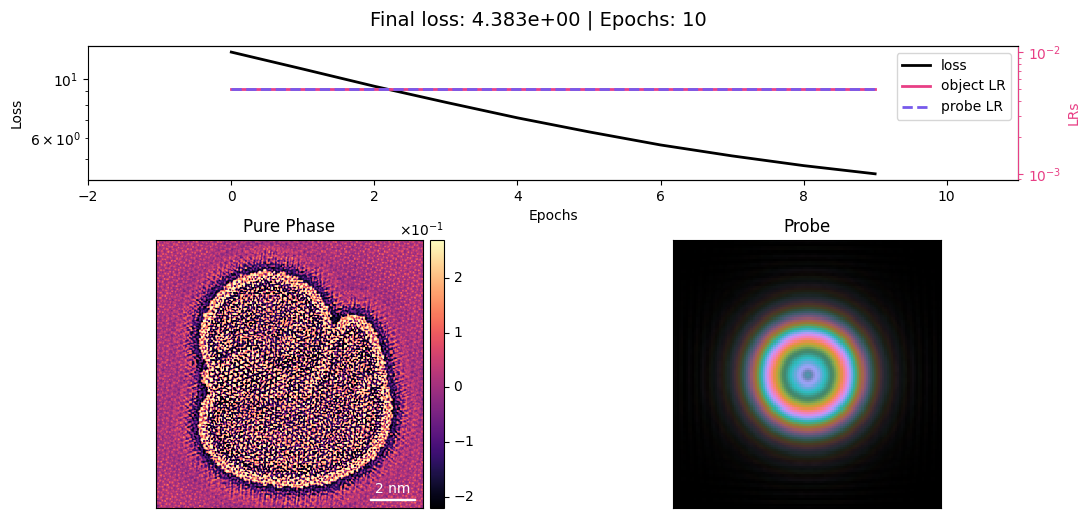

In [23]:
## quick bad recon for pretraining the DIP 
## (unfair to have a converged/good reconstruction as the input, though this does often lead
## to the best possible reconstruction)
ptycho.reconstruct(
    num_iter=10,
    reset=True,
).visualize()


## DIP

Epoch 50/50, Loss: 2.495e-03, : 100%|██████████| 50/50 [00:01<00:00, 48.58it/s]
/home/amccray/code/quantem/src/quantem/core/visualization/visualization.py:547: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


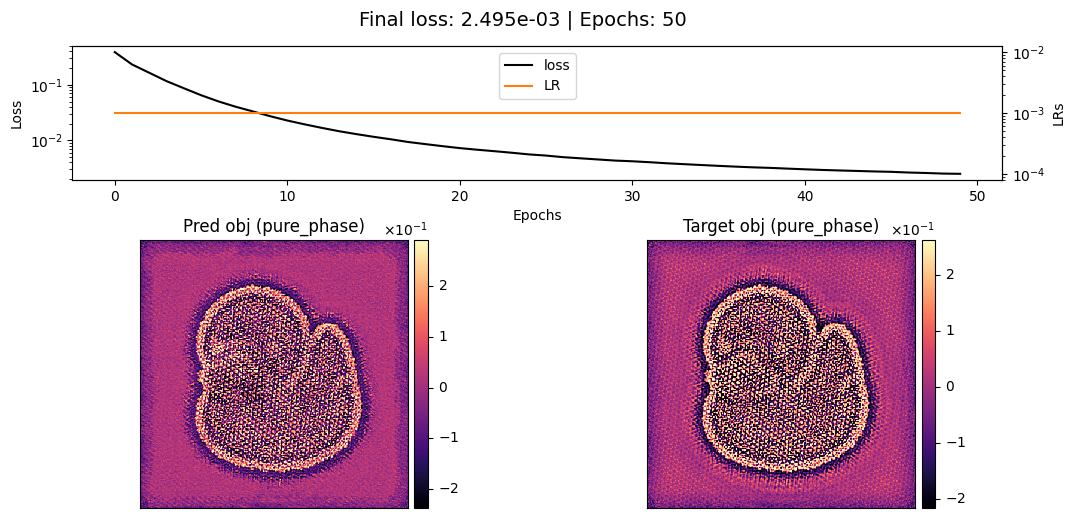

Epoch 50/50, Loss: 1.307e+00, : 100%|██████████| 50/50 [00:02<00:00, 21.19it/s]
/home/amccray/code/quantem/src/quantem/core/visualization/visualization.py:547: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


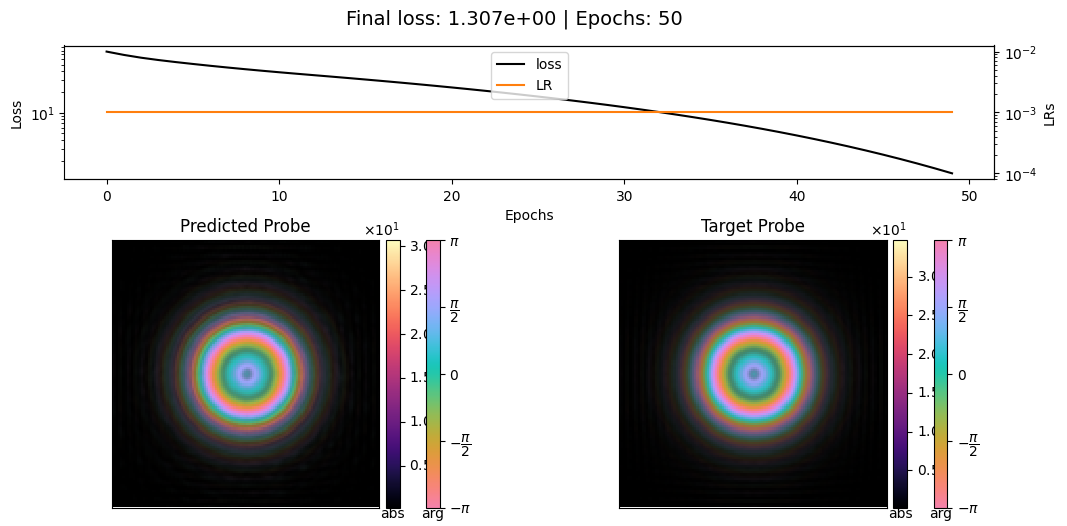

In [24]:
model_dip = CNN2d(
    in_channels=1,
    use_skip_connections=True,
    dtype=torch.float32,
    # final_activation="relu",
)

obj_model_dip = ObjectDIP.from_model(
    model=model_dip,
    model_input=ptycho.obj_model.obj.angle(), 
    obj_type="pure_phase",
    rng=42,
    device=config.get("device"),
)

probe_dip = CNN2d(
    in_channels=1,
    use_skip_connections=True,
    dtype = torch.complex64,
)

probe_model_dip = ProbeDIP.from_model(
    model=probe_dip,
    model_input=ptycho.probe_model.probe,
    num_probes=1,
    device=config.get("device"),
)

obj_model_dip.pretrain(
    reset=True,
    num_epochs=50,
    pretrain_target=ptycho.obj_model.obj.angle(),
    optimizer_params={
        "type": torch.optim.Adam,
        "lr": 1e-3,
    },
    scheduler_params={
        "type": "plateau",
        "factor": 0.5,
    },
    apply_constraints=False,
)

probe_model_dip.pretrain(
    reset=True,
    num_epochs=50,
    pretrain_target=ptycho.probe_model.probe,
    optimizer_params={
        "type": torch.optim.Adam,
        "lr": 1e-3,
    },
    scheduler_params={
        "type": "plateau",
        "factor": 0.5,
    },
    apply_constraints=False,
)

ptycho_dip = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model_dip,
    probe_model=probe_model_dip,
    detector_model=detector_model,
    device="gpu",
    logger=logger,
)

ptycho_dip.preprocess(
    obj_padding_px=(32, 32),
)

Epoch 25/25, Loss: 1.815e+00: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


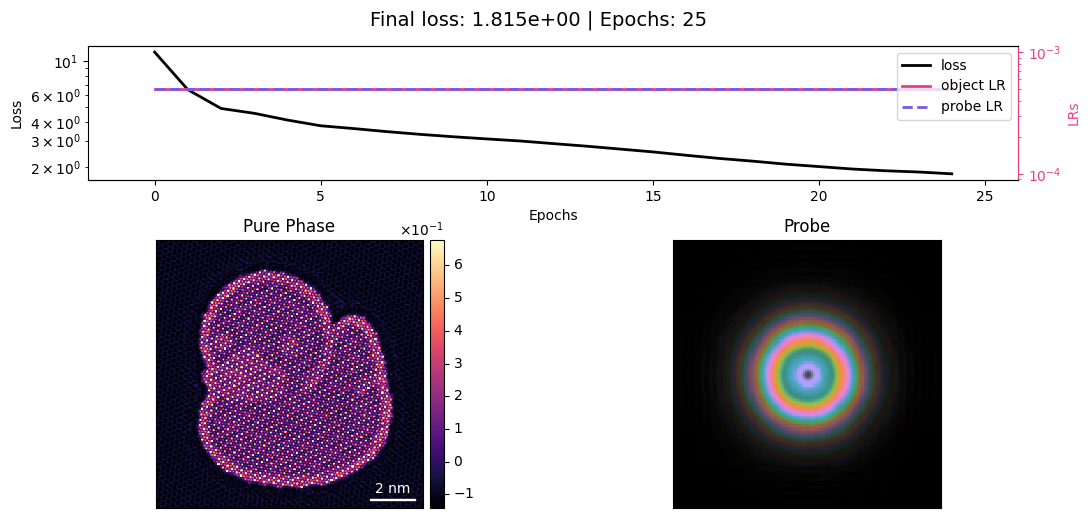

In [25]:
opt_params = {  
    "object": {
        "type": "adam",  
        "lr": 5e-4,
    },
    "probe": {
        "type": "adam",
        "lr": 5e-4,
    },
}

scheduler_params = {
    # "object": {
    #     "type": "plateau",
    # },
    # "probe": {
    #     "type": "plateau",
    # },
}
constraints = {
}

# ptycho.remove_optimizer("probe")
ptycho_dip.reconstruct(
    num_iter=25,
    reset=True,
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    constraints=constraints,
    batch_size=128,
).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'DIP pure_phase | 25 epochs'}>,
        <Axes: title={'center': 'DIP zoom'}>,
        <Axes: title={'center': 'DIP zoom'}>], dtype=object))

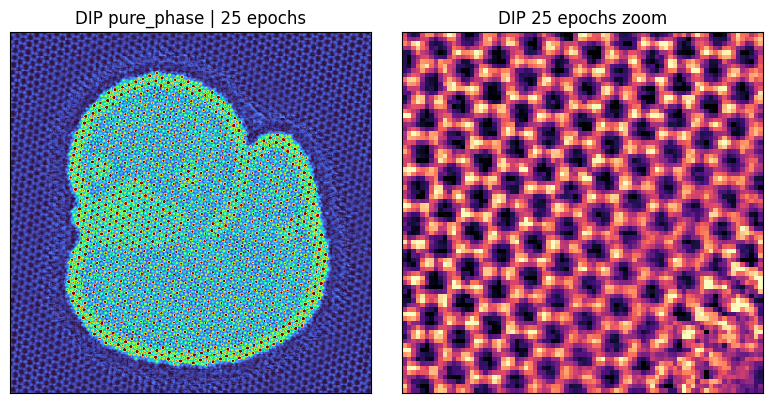

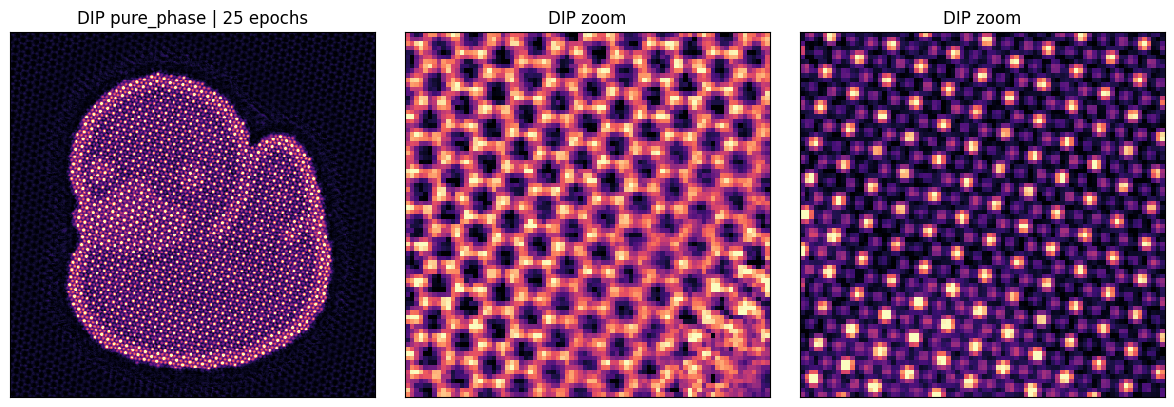

In [26]:
show_2d(
    [np.angle(ptycho_dip.obj_cropped[0]), np.angle(ptycho_dip.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs", f"DIP {ptycho_dip.num_epochs} epochs zoom"]
)
show_2d(
    [
        np.angle(ptycho_dip.obj_cropped[0]),
        np.angle(ptycho_dip.obj_cropped[0, :80, :80]),
        np.angle(ptycho_dip.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs", "DIP zoom", "DIP zoom"],
)

Epoch 100/100, Loss: 1.444e+00: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


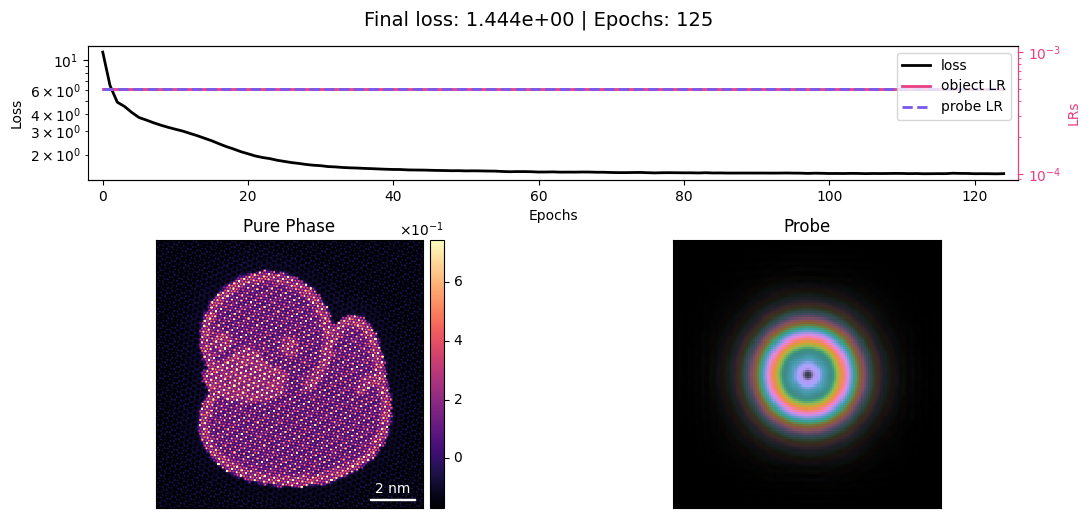

In [27]:
ptycho_dip.reconstruct(
    num_iter=100,
).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'DIP pure_phase | 125 epochs'}>,
        <Axes: title={'center': 'DIP zoom'}>,
        <Axes: title={'center': 'DIP zoom'}>], dtype=object))

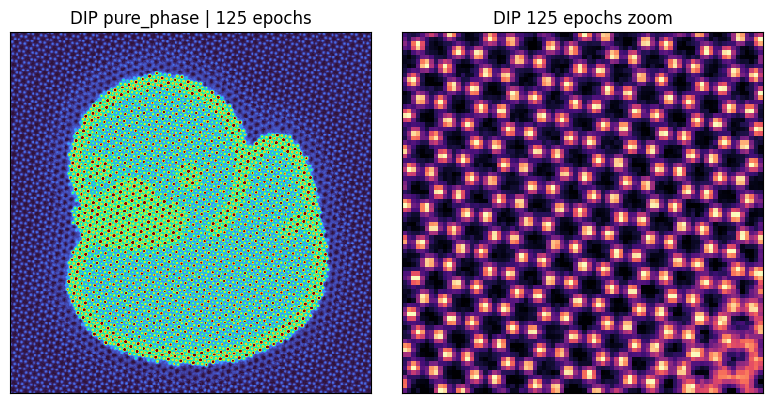

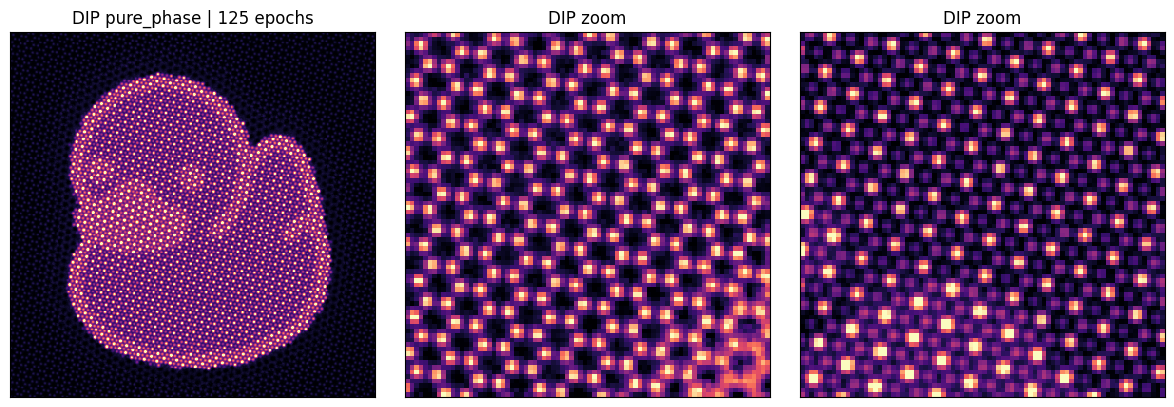

In [28]:
show_2d(
    [np.angle(ptycho_dip.obj_cropped[0]), np.angle(ptycho_dip.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs", f"DIP {ptycho_dip.num_epochs} epochs zoom"]
)
show_2d(
    [
        np.angle(ptycho_dip.obj_cropped[0]),
        np.angle(ptycho_dip.obj_cropped[0, :80, :80]),
        np.angle(ptycho_dip.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs", "DIP zoom", "DIP zoom"],
)

## save/load

In [29]:
ptycho_dip.save("../data/ptycho_dip.zip", mode='o')

In [30]:
ptycho_dip2 = Ptychography.from_file("../data/ptycho_dip.zip")

Successfully reloaded dataset from /home/amccray/code/quantem-tutorials/data/ducky_clean.zip


Epoch 10/10, Loss: 1.441e+00: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


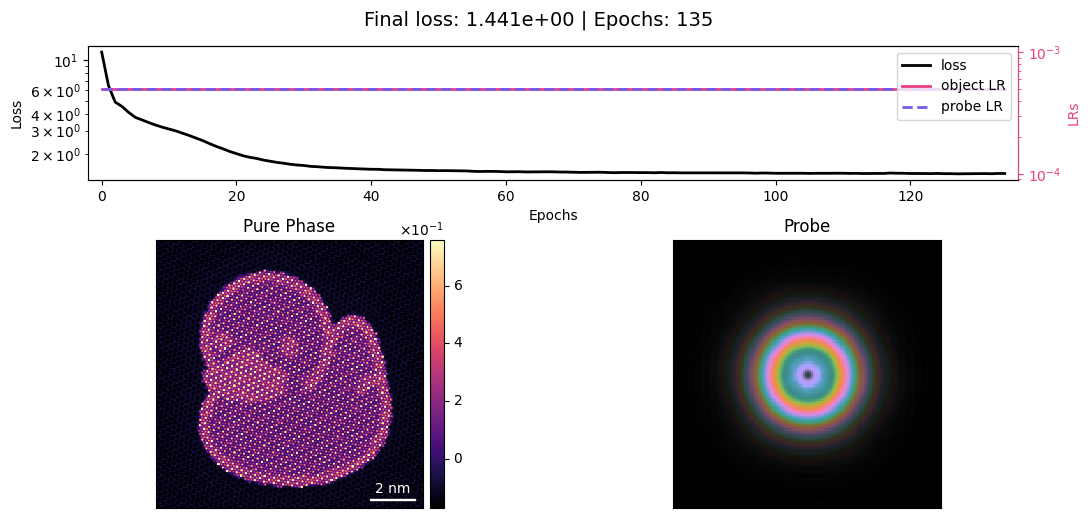

In [ ]:
ptycho_dip2.reconstruct(
    num_iter=15,
    device='gpu',
).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'DIP pure_phase | 135 epochs'}>,
        <Axes: title={'center': 'DIP zoom'}>,
        <Axes: title={'center': 'DIP zoom'}>], dtype=object))

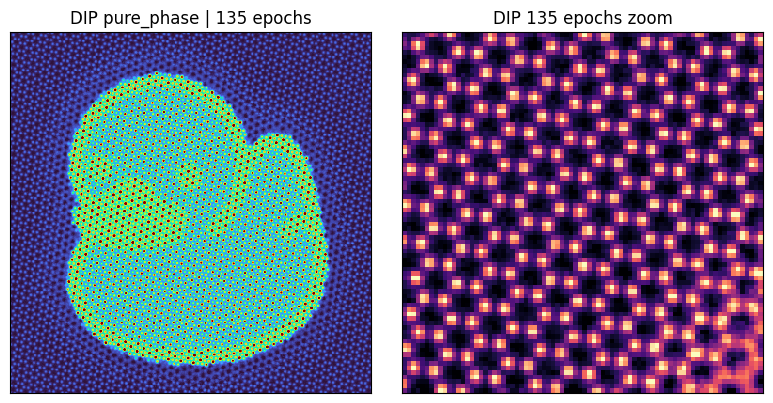

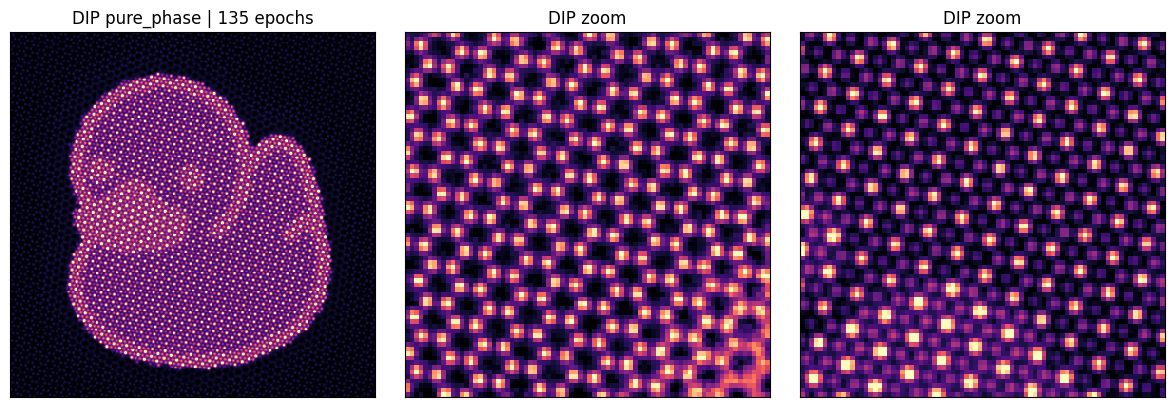

In [32]:
show_2d(
    [np.angle(ptycho_dip2.obj_cropped[0]), np.angle(ptycho_dip2.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title=[f"DIP {ptycho_dip2.obj_model.obj_type} | {ptycho_dip2.num_epochs} epochs", f"DIP {ptycho_dip2.num_epochs} epochs zoom"]
)
show_2d(
    [
        np.angle(ptycho_dip2.obj_cropped[0]),
        np.angle(ptycho_dip2.obj_cropped[0, :80, :80]),
        np.angle(ptycho_dip2.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[f"DIP {ptycho_dip2.obj_model.obj_type} | {ptycho_dip2.num_epochs} epochs", "DIP zoom", "DIP zoom"],
)